In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("src", "/home/anuiel/Remote/Anuiel/sound-dz-1/pytorch_project_template/src/__init__.py")
src = importlib.util.module_from_spec(spec)

sys.modules["src"] = src
spec.loader.exec_module(src)

## CTCEncoder testing

**TODO**

- BPE
- Beam Search
- LM perplexity score (probably [meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B))

In [3]:
from src.datasets import LibrispeechDataset
from src.text_encoder import CTCTextEncoder

In [5]:
text_encoder = CTCTextEncoder()
instance_transforms = {
    "get_spectrogram": lambda x: x
}
dataset = LibrispeechDataset(part="dev-clean", text_encoder=text_encoder, instance_transforms=instance_transforms)

In [7]:
import IPython

x = dataset[1448]

IPython.display.Audio(x['audio_path'])

In [8]:
x['text_encoded'].shape, x["audio"].shape, x['spectrogram'].shape

(torch.Size([1, 104]), torch.Size([1, 101280]), torch.Size([1, 101280]))

In [9]:
from torchaudio.pipelines import WAV2VEC2_ASR_BASE_100H

bundle = WAV2VEC2_ASR_BASE_100H

model = bundle.get_model()

In [10]:
import torchaudio

waveform = torchaudio.functional.resample(x['audio'], dataset.target_sr, bundle.sample_rate)
labels = bundle.get_labels()

In [11]:
text_to_target = {
    letter.lower(): idx
    for idx, letter in enumerate(labels)
}

text_to_target[" "] = text_to_target["|"]

In [12]:
import torch

emissions, _ = model(waveform)
target = torch.tensor([text_to_target[letter] for letter in x['text']]).unsqueeze(0)

In [13]:
emissions.shape

torch.Size([1, 316, 29])

In [14]:
emission = emissions.squeeze(0)

In [15]:
from src.text_encoder import CTCTextEncoder

custom_encoder = CTCTextEncoder()

custom_encoder.EMPTY_TOK = "-"
custom_encoder.vocab = labels

custom_encoder.ind2char = dict(enumerate(custom_encoder.vocab))
custom_encoder.char2ind = {v: k for k, v in custom_encoder.ind2char.items()}
custom_encoder.EMPTY_IND = custom_encoder.char2ind[custom_encoder.EMPTY_TOK]

In [16]:
emissions.argmax(-1).squeeze(0).shape

torch.Size([316])

In [54]:
from src.text_encoder import CTCArgmaxDecoder, CTCBeamSearchDecoder

argmax_decoder = CTCArgmaxDecoder()
print(custom_encoder.decode(argmax_decoder.decode(emissions)[0]))
print(x['text'])

THESE|SACRED|EDIFICES|ARE|HOWEVER|VERY|MUCH|LIKE|THESE|PEOPLE|WHO|DO|WITHOUT|WATCHES|AND|NEVER|MISS|THEM|
these sacred edifices are however very much like these people who do without watches and never miss them


In [55]:
beam_search_decoder = CTCBeamSearchDecoder(beam_size=1)
print(custom_encoder.decode(beam_search_decoder.decode(emissions)[0]))

THESE|SACRED|EDIFICES|ARE|HOWEVER|VERY|MUCH|LIKE|THESE|PEOPLE|WHO|DO|WITHOUT|WATCHES|AND|NEVER|MIS|THEM|


In [56]:
beam_search_decoder.decode(emissions)[0]

tensor([ 3,  8,  2,  9,  2,  1,  9,  4, 16, 10,  2, 11,  1,  2, 11,  7, 17,  7,
        16,  2,  9,  1,  4, 10,  2,  1,  8,  5, 15,  2, 22,  2, 10,  1, 22,  2,
        10, 19,  1, 14, 13, 16,  8,  1, 12,  7, 23,  2,  1,  3,  8,  2,  9,  2,
         1, 20,  2,  5, 20, 12,  2,  1, 15,  8,  5,  1, 11,  5,  1, 15,  7,  3,
         8,  5, 13,  3,  1, 15,  4,  3, 16,  8,  2,  9,  1,  4,  6, 11,  1,  6,
         2, 22,  2, 10,  1, 14,  7,  9,  9,  1,  3,  8,  2, 14,  1])

In [22]:
from torchaudio.models.decoder import ctc_decoder

smart_decoder = ctc_decoder(
    lexicon=None,
    tokens=custom_encoder.vocab,
    blank_token=custom_encoder.EMPTY_TOK,
    beam_size=1
)

In [30]:
result = smart_decoder(torch.stack((emission, emission)))

custom_encoder.decode_raw(result[0][0].tokens)

'|THESE|SACRED|EDIFICES|ARE|HOWEVER|VERY|MUCH|LIKE|THESE|PEOPLE|WHO|DO|WITHOUT|WATCHES|AND|NEVER|MISS|THEM||'

In [25]:
import math
import collections

NEG_INF = -float("inf")

def make_new_beam():
  fn = lambda : (NEG_INF, NEG_INF)
  return collections.defaultdict(fn)

def logsumexp(*args):
  """
  Stable log sum exp.
  """
  if all(a == NEG_INF for a in args):
      return NEG_INF
  a_max = max(args)
  lsp = math.log(sum(math.exp(a - a_max)
                      for a in args))
  return a_max + lsp

def decode(probs, beam_size=100, blank=0):
  """
  Performs inference for the given output probabilities.
  Arguments:
      probs: The output probabilities (e.g. post-softmax) for each
        time step. Should be an array of shape (time x output dim).
      beam_size (int): Size of the beam to use during inference.
      blank (int): Index of the CTC blank label.
  Returns the output label sequence and the corresponding negative
  log-likelihood estimated by the decoder.
  """
  T, S = probs.shape

  # Elements in the beam are (prefix, (p_blank, p_no_blank))
  # Initialize the beam with the empty sequence, a probability of
  # 1 for ending in blank and zero for ending in non-blank
  # (in log space).
  beam = [(tuple(), (0.0, NEG_INF))]

  for t in range(T): # Loop over time

    # A default dictionary to store the next step candidates.
    next_beam = make_new_beam()

    for s in range(S): # Loop over vocab
      p = probs[t, s]

      # The variables p_b and p_nb are respectively the
      # probabilities for the prefix given that it ends in a
      # blank and does not end in a blank at this time step.
      for prefix, (p_b, p_nb) in beam: # Loop over beam

        # If we propose a blank the prefix doesn't change.
        # Only the probability of ending in blank gets updated.
        if s == blank:
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_b = logsumexp(n_p_b, p_b + p, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)
          continue

        # Extend the prefix by the new character s and add it to
        # the beam. Only the probability of not ending in blank
        # gets updated.
        end_t = prefix[-1] if prefix else None
        n_prefix = prefix + (s,)
        n_p_b, n_p_nb = next_beam[n_prefix]
        if s != end_t:
          n_p_nb = logsumexp(n_p_nb, p_b + p, p_nb + p)
        else:
          # We don't include the previous probability of not ending
          # in blank (p_nb) if s is repeated at the end. The CTC
          # algorithm merges characters not separated by a blank.
          n_p_nb = logsumexp(n_p_nb, p_b + p)
          
        # *NB* this would be a good place to include an LM score.
        next_beam[n_prefix] = (n_p_b, n_p_nb)

        # If s is repeated at the end we also update the unchanged
        # prefix. This is the merging case.
        if s == end_t:
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_nb = logsumexp(n_p_nb, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)

    # Sort and trim the beam before moving on to the
    # next time-step.
    beam = sorted(next_beam.items(),
            key=lambda x : logsumexp(*x[1]),
            reverse=True)
    beam = beam[:beam_size]

  best = beam[0]
  return best[0], -logsumexp(*best[1])

In [28]:
ans, p = decode(emission, beam_size=1)

custom_encoder.decode_raw(ans)

'THESE|SACRED|EDIFICES|ARE|HOWEVER|VERY|MUCH|LIKE|THESE|PEOPLE|WHO|DO|WITHOUT|WATCHES|AND|NEVER|MISS|THEM|'

In [168]:
from dataclasses import dataclass
import math


INF = float('inf')
blank = 0
beam_size = 400

def stable_log_prob_sum(*args: float) -> float:
    """
    Calculates log(\\sum_{k=1}^n exp(a_k)) numericly stable 
    """
    if all(a == -INF for a in args):
        return -INF
    maximum = max(args)
    return maximum + math.log(sum(math.exp(x - maximum) for x in args))

In [169]:
from collections import defaultdict

current_beams = [
    (tuple(), (0.0, -INF))
]

for t in range(emission.shape[0]):
    print(f"At {t=} prefixes are")
    for prefix, _ in current_beams[:5]:
        print('\t', custom_encoder.decode(prefix))
    print()

    next_beams = defaultdict(lambda: (-INF, -INF)) # so if no such prefix exists then all probs are 0
    for c in range(emission.shape[1]):
        p = emission[t, c].item()
        for prefix, (p_bl, p_n_bl) in current_beams:
            if c == blank:
                next_p_bl, next_p_n_bl = next_beams[prefix]
                # for this prefix with black at the end we have new 2 valid paths
                next_p_bl = stable_log_prob_sum(next_p_bl, p_bl + p, p_n_bl + p)
                next_beams[prefix] = (next_p_bl, next_p_n_bl)
            else: # c != blank
                end_prefix_char = prefix[-1] if prefix else None
                new_prefix = prefix + (c,)

                next_p_bl, next_p_n_bl = next_beams[new_prefix]

                if end_prefix_char == c:
                    # if chars are same we can add only to prefix with blank
                    next_p_n_bl = stable_log_prob_sum(next_p_n_bl, p_bl + p)

                    # But we can actually append char, that only update old prefix
                    old_p_bl, old_p_n_bl = next_beams[prefix]
                    old_p_n_bl = stable_log_prob_sum(old_p_n_bl, p_n_bl + p)
                    next_beams[prefix] = (old_p_bl, old_p_n_bl)
                else:
                    # no merge would happend, 
                    next_p_n_bl = stable_log_prob_sum(next_p_n_bl, p_bl + p, p_n_bl + p)

                next_beams[new_prefix] = (next_p_bl, next_p_n_bl)
    current_beams = sorted(
        next_beams.items(),
        key=lambda x : stable_log_prob_sum(*x[1]),
        reverse=True
    )
    current_beams = current_beams[:beam_size]

best, (p_bl, p_n_bl) = current_beams[0]

print(custom_encoder.decode(best))

At t=0 prefixes are
	 

At t=1 prefixes are
	 
	 U
	 P
	 T
	 B

At t=2 prefixes are
	 
	 U
	 P
	 T
	 B

At t=3 prefixes are
	 
	 T
	 B
	 A
	 U

At t=4 prefixes are
	 
	 T
	 B
	 A
	 U

At t=5 prefixes are
	 
	 T
	 B
	 A
	 S

At t=6 prefixes are
	 
	 T
	 B
	 A
	 S

At t=7 prefixes are
	 
	 T
	 B
	 A
	 S

At t=8 prefixes are
	 
	 T
	 B
	 A
	 S

At t=9 prefixes are
	 
	 T
	 B
	 A
	 W

At t=10 prefixes are
	 
	 T
	 I
	 B
	 U

At t=11 prefixes are
	 
	 T
	 U
	 |
	 I

At t=12 prefixes are
	 
	 T
	 |
	 I
	 U

At t=13 prefixes are
	 T
	 
	 D
	 B
	 W

At t=14 prefixes are
	 TH
	 T
	 H
	 
	 DH

At t=15 prefixes are
	 TH
	 H
	 T
	 DH
	 BH

At t=16 prefixes are
	 THE
	 THA
	 THI
	 HE
	 TE

At t=17 prefixes are
	 THE
	 THET
	 THA
	 THE|
	 THAT

At t=18 prefixes are
	 THE|
	 THET|
	 THA|
	 THAT|
	 THEI|

At t=19 prefixes are
	 THE|R
	 THET|R
	 THA|R
	 THAT|R
	 THEI|R

At t=20 prefixes are
	 THE|R
	 THET|R
	 THA|R
	 THAT|R
	 THEI|R

At t=21 prefixes are
	 THE|RO
	 THE|R
	 THET|RO
	 THET|R
	 THA|RO

At

## Spectrogram gaming

In [77]:
from src.datasets import LibrispeechDataset
from src.text_encoder import CTCTextEncoder
import torchaudio

text_encoder = CTCTextEncoder()
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
)
instance_transforms = {
    "get_spectrogram": lambda x: mel_spectrogramer(x)
}
dataset = LibrispeechDataset(part="train-clean-100", text_encoder=text_encoder, instance_transforms=instance_transforms)

In [78]:
# from https://github.com/markovka17/dla/blob/2024/week03/seminar03_1.ipynb
from IPython import display
from matplotlib import pyplot as plt
import torchaudio

import torch
import torch.nn.functional as F

In [79]:
import IPython

x = dataset[2000]


In [87]:
x['spectrogram'].max()

tensor(3497.5073)

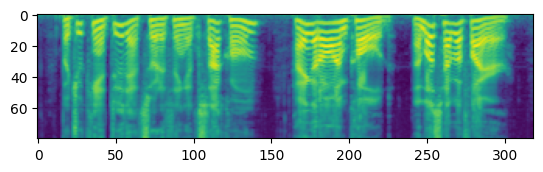

In [96]:
plt.imshow(torch.log(x['spectrogram'].squeeze(0) + 1e-6))

In [9]:
from tqdm import tqdm

mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=dataset.target_sr,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
)

mx = 0
for item in tqdm(dataset):
    mel = mel_spectrogramer(item['audio'])
    mx = max(mx, mel.shape[-1])

print(mx)

100%|██████████| 28539/28539 [02:34<00:00, 184.24it/s]

1533


In [5]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=dataset.target_sr,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
)

In [6]:
x = dataset[2222]
audio = x['audio']
sr = dataset.target_sr


mel_spectrogram = mel_spectrogramer(audio).squeeze(0)

print(x['text']), mel_spectrogram.shape

am i come to a friend she asked in a tone full of mournful dignity


(None, torch.Size([80, 340]))

In [7]:
from src.model.conformer import Conformer

conformer = Conformer(
    n_features=80,
    n_hidden=160,
    n_layers=2,
    n_heads=4,
    depthwise_conv_kernel_size=31,
    max_seq_len=340,
    dropout=0.1
)

In [8]:
spectorgramm = mel_spectrogram.unsqueeze(0)
spectorgramm_lenght = torch.tensor([340])

In [9]:
conformer(spectorgramm, spectorgramm_lenght)

{'log_probs': tensor([[[-4.0912, -5.6356, -3.9448,  ..., -4.0329, -4.3350, -4.2843],
          [-4.4711, -4.0174, -3.9279,  ..., -2.9171, -4.8172, -3.3770],
          [-5.2882, -5.3091, -4.5926,  ..., -4.0634, -4.8899, -4.0330],
          ...,
          [-2.5529, -4.6399, -2.6462,  ..., -4.9620, -4.0127, -3.7655],
          [-1.8646, -4.0093, -5.5421,  ..., -4.9126, -3.7893, -4.2840],
          [-3.2249, -5.4149, -4.4284,  ..., -5.1673, -5.4629, -3.7144]]],
        grad_fn=<LogSoftmaxBackward0>),
 'log_probs_length': tensor([340])}

In [9]:
a = plot_spectrogram(mel_spectrogram)

(2000, 500)


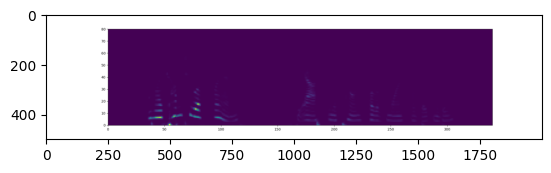

In [13]:
aa = plt.imshow(a.transpose(0, 1).transpose(1, 2).numpy())
plt.show()

In [12]:
mel_spectrogram = mel_spectrogramer(audio)
log_mel_spectrogram = torch.log(mel_spectrogram).squeeze()
plt.figure(figsize=(20, 5))
plt.imshow(log_mel_spectrogram)
plt.show()

In [116]:
log_mel_spectrogram.shape

torch.Size([80, 248])

## CER and WER

2